# Continuous Control

---


### 1. Introduction

#### This notebook was run in the Udacity coding environment to train my agent for the project **Option 2**.

For this project, you will work with the [Reacher](https://www.youtube.com/watch?v=2N9EoF6pQyE&feature=youtu.be).

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

#### Distributed Training

For this project, we will provide you with two separate versions of the Unity environment:

* The first version contains a single agent.
* The second version contains 20 identical agents, each with its own copy of the environment.

The second version is useful for algorithms like [PPO](https://arxiv.org/pdf/1707.06347.pdf), [A3C](https://arxiv.org/pdf/1602.01783.pdf), and [D4PG](https://openreview.net/pdf?id=SyZipzbCb) that use multiple (non-interacting, parallel) copies of the same agent to distribute the task of gathering experience.

#### Solving the Environment

*Note that your project submission need only solve one of the two versions of the environment.*

##### Option 1: Solve the First Version

The task is episodic, and in order to solve the environment, your agent must get an average score of +30 over 100 consecutive episodes.

##### Option 2: Solve the Second Version

The barrier for solving the second version of the environment is slightly different, to take into account the presence of many agents. In particular, your agents must get an average score of +30 (over 100 consecutive episodes, and over all agents). Specifically,

* After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 20 (potentially different) scores. We then take the average of these 20 scores.
* This yields an average score for each episode (where the average is over all 20 agents).

The environment is considered solved, when the average (over 100 episodes) of those average scores is at least +30.


* The present **Jupyter Notebook** includes functional, well-documented code, and organized code for training the agent.
* The **Readme** file of this repository describes the project environment, provides instructions for installing dependencies or downloading needed files, and how to run the code to train the agent.
* The **Report** provides a description of the implementation of this project, including a plot of rewards and ideas for future improvements.

### 2. Start the Environment

We begin by importing the necessary packages.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environments corresponding to the Version 2 environment is already saved in the Workspace and can be accessed at the file paths provided below.

We are loading version 2 of the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')


# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 4. Setting up my own agent

*The agent cannot be watched while training in the Udacity coding environment.*

In [5]:
# keep the Udacity workspace awake during long training tasks
import workspace_utils

In [6]:
# necessary imports
import random
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from collections import namedtuple, deque
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Model

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed   = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
       
    
# DDPG Agent

BUFFER_SIZE = int(5e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0       # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, epsilon=1.0, epsilon_decay=1e-5):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    
    def step(self, state, action, reward, next_state, done, epoch):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and epoch % 20 == 0:
            for num in range(20):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.epsilon * self.noise.sample()
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
        self.epsilon -= self.epsilon_decay
        self.noise.reset()


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.05):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""   
        for num in range(20):
            e = self.experience(state[num], action[num], reward[num], next_state[num], done[num])
            self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.choices(self.memory, k=self.batch_size)        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 5. Train the agent with DDPG

In [8]:
# instantiate agent
agent = Agent(state_size=33, action_size=4, random_seed=2)

In [9]:
from workspace_utils import active_session

def ddpg(n_episodes=1000, max_t=1000000, solved_score=30.0, train_mode=True):
    with active_session():
        all_agents = np.array([]).reshape(0,20)
        start_time = time.time()

    
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=train_mode)[brain_name]      # reset the environment    
            states = env_info.vector_observations                        # get the current state for all 20 agents
            scores = np.zeros(20)                                        # initialize the score for all 20 agents
            agent.reset()
        
            score_average = 0
            timestep = time.time()
            for t in range(max_t):
                actions = agent.act(states, add_noise=True)
                env_info = env.step(actions)[brain_name]           # send all actions to tne environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # check if episode is completed            
                agent.step(states, actions, rewards, next_states, dones,t)
                states = next_states                               # roll over states to next time step
                scores += rewards                                  # update the score (for each agent)           
                if np.any(dones):                                  # exit loop if episode is completed
                    break
        
            all_agents = np.concatenate((all_agents, scores.reshape(1,20)), axis=0)
            mean_100 = np.mean(all_agents[-101:-1], axis=0)      
            print('\rEpisode {} -- \tMin: {:.2f}\tMax:  {:.2f}\tMean: {:.2f}\tMean100:{:.2f}\tTime {:.2f}'\
                  .format(str(i_episode).zfill(3), np.min(scores), np.max(scores), np.mean(scores), float(np.mean(mean_100)), 
                          time.time() - timestep), end="\n")                                   
            if  np.all(mean_100 > 30.0):            
                end_time = time.time()
                print('\nThe Reacher Environment Option 2 was Solved in {:d} episodes!\tAvg Score: {:.2f}, time: {}'.format(i_episode, float(np.mean(mean_100)), 
                                                                                   end_time-start_time))
                for num, scr in enumerate(mean_100):
                    print('Agent {} average: {:.2f} '.format(num+1, scr))        
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') 
                return all_agents

### 6. Getting there!

In [10]:
# Run the training loop and monitor the scores
scores = ddpg()


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


Episode 001 -- 	Min: 0.00	Max:  0.44	Mean: 0.16	Mean100:nan	Time 17.05
Episode 002 -- 	Min: 0.00	Max:  0.85	Mean: 0.24	Mean100:0.16	Time 17.42
Episode 003 -- 	Min: 0.00	Max:  0.89	Mean: 0.35	Mean100:0.20	Time 17.57
Episode 004 -- 	Min: 0.00	Max:  1.27	Mean: 0.51	Mean100:0.25	Time 17.78
Episode 005 -- 	Min: 0.11	Max:  2.00	Mean: 0.77	Mean100:0.32	Time 18.20
Episode 006 -- 	Min: 0.11	Max:  2.10	Mean: 0.96	Mean100:0.41	Time 18.15
Episode 007 -- 	Min: 0.00	Max:  2.68	Mean: 0.88	Mean100:0.50	Time 18.29
Episode 008 -- 	Min: 0.20	Max:  2.52	Mean: 1.03	Mean100:0.55	Time 18.47
Episode 009 -- 	Min: 0.29	Max:  2.18	Mean: 1.01	Mean100:0.61	Time 18.64
Episode 010 -- 	Min: 0.18	Max:  2.59	Mean: 1.15	Mean100:0.66	Time 19.00
Episode 011 -- 	Min: 0.45	Max:  3.30	Mean: 1.37	Mean100:0.71	Time 19.20
Episode 012 -- 	Min: 0.00	Max:  2.86	Mean: 1.45	Mean100:0.77	Time 19.56
Episode 013 -- 	Min: 0.06	Max:  2.68	Mean: 1.22	Mean100:0.82	Time 19.78
Episode 014 -- 	Min: 0.22	Max:  3.34	Mean: 1.68	Mean100:0.85	Time

### 6. Visualization

Text(0.5,0,'Episode #')

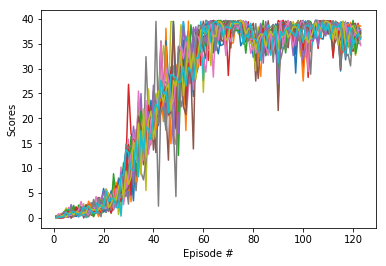

In [11]:
# plot the scores
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Scores')
plt.xlabel('Episode #')

The environment needs to be closed.

In [ ]:
env.close()